In [1]:
# importing our functions
from utilities import  add_team_possession, add_adjusted_eventSec, calculate_team_scores, calculate_bin_number, generate_bins_properties
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for random forests  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm
import pickle
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
  

In [2]:
# Liste des fichiers JSON
file_names = ['events_England.json', 'events_France.json', 'events_Spain.json', 'events_Germany.json', 'events_Italy.json']

# Initialiser un DataFrame vide
event_data = pd.DataFrame()

# Boucler à travers les fichiers et les charger
for file_name in file_names:
    with open(file_name) as f:
        data = json.load(f)
    # Concaténer les nouvelles données au DataFrame existant
    event_data = pd.concat([event_data, pd.DataFrame(data)], ignore_index=True)


event_data



,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160
3071391,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161
3071392,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163
3071393,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162


In [3]:
data = calculate_team_scores(event_data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,team_scores,is_goal
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0,False
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0,False
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,0,False
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0,False
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,-1,False
3071391,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,1,False
3071392,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,-1,False
3071393,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,1,False


In [4]:
#First goal detected
data.iloc[40:50]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,team_scores,is_goal
40,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 14, 'x': 96}, {'y': 3, 'x': 90}]",2499719,Duel,1609,1H,85.074043,11,177959201,0,False
41,1,Ground defending duel,"[{'id': 502}, {'id': 701}, {'id': 1802}]",0,"[{'y': 86, 'x': 4}, {'y': 97, 'x': 10}]",2499719,Duel,1631,1H,85.074043,12,177961220,0,False
42,8,Simple pass,[{'id': 1801}],7868,"[{'y': 3, 'x': 90}, {'y': 13, 'x': 72}]",2499719,Pass,1609,1H,86.773457,85,177959203,0,False
43,8,High pass,[{'id': 1801}],49876,"[{'y': 13, 'x': 72}, {'y': 86, 'x': 86}]",2499719,Pass,1609,1H,89.249387,83,177959207,0,False
44,8,Simple pass,[{'id': 1801}],167145,"[{'y': 86, 'x': 86}, {'y': 71, 'x': 73}]",2499719,Pass,1609,1H,93.115548,85,177959208,0,False
45,8,Cross,"[{'id': 301}, {'id': 402}, {'id': 801}, {'id':...",120339,"[{'y': 71, 'x': 73}, {'y': 41, 'x': 88}]",2499719,Pass,1609,1H,93.961235,80,177959211,0,False
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,0,True
47,9,Reflexes,"[{'id': 101}, {'id': 1205}, {'id': 1802}]",8480,"[{'y': 100, 'x': 100}, {'y': 59, 'x': 12}]",2499719,Save attempt,1631,1H,96.970614,90,177959226,-1,False
48,1,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",8013,"[{'y': 6, 'x': 75}, {'y': 6, 'x': 82}]",2499719,Duel,1631,1H,147.157528,13,177959231,-1,False
49,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",3319,"[{'y': 94, 'x': 25}, {'y': 94, 'x': 18}]",2499719,Duel,1609,1H,147.633740,13,177959218,1,False


In [5]:
data = add_adjusted_eventSec(data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,team_scores,is_goal,adjusted_eventSec
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0,False,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0,False,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,0,False,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0,False,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0,False,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071390,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,-1,False,5746.059044
3071391,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161,1,False,5747.177526
3071392,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,-1,False,5748.066821
3071393,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162,1,False,5749.125590


In [6]:
data = add_team_possession(data)
data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,team_scores,is_goal,adjusted_eventSec,possession_duration,team_possession
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0,False,2.758649,2.758649,2.758649
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0,False,4.946850,2.188201,4.946850
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,0,False,6.542188,1.595338,6.542188
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0,False,8.143395,1.601207,8.143395
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0,False,10.302366,2.158971,10.302366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071386,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,-1,False,5693.313549,0.627653,3475.451269
3071387,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,-1,False,5698.174956,4.861407,3480.312676
3071390,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,-1,False,5746.059044,46.240805,3526.553481
3071392,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,-1,False,5748.066821,0.889295,3527.442776


In [7]:
data['possession_percent'] = data['team_possession']/data['adjusted_eventSec']

data

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,team_scores,is_goal,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,0,False,2.758649,2.758649,2.758649,1.000000
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,0,False,4.946850,2.188201,4.946850,1.000000
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,0,False,6.542188,1.595338,6.542188,1.000000
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,0,False,8.143395,1.601207,8.143395,1.000000
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,0,False,10.302366,2.158971,10.302366,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071386,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",116269,"[{'y': 15, 'x': 78}, {'y': 18, 'x': 74}]",2576338,Duel,3193,2H,2818.237165,11,253567151,-1,False,5693.313549,0.627653,3475.451269,0.610444
3071387,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",116269,"[{'y': 18, 'x': 74}, {'y': 13, 'x': 76}]",2576338,Duel,3193,2H,2823.098572,11,253567155,-1,False,5698.174956,4.861407,3480.312676,0.610777
3071390,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160,-1,False,5746.059044,46.240805,3526.553481,0.613734
3071392,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163,-1,False,5748.066821,0.889295,3527.442776,0.613675


# Filtering out all the shots from our dataset

In [8]:
# Filtering out all the shots from our dataset
shots_df = data[data['subEventName']=='Shot'].reset_index(drop=True)
shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,team_scores,is_goal,adjusted_eventSec,possession_duration,team_possession,possession_percent
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,0,True,94.595788,0.634553,72.105703,0.762251
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,0,False,425.824035,2.064568,219.635022,0.515788
2,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,0,False,815.462015,1.457973,390.934751,0.479403
3,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",7945,"[{'y': 39, 'x': 90}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1286.061650,100,177959606,0,False,1286.061650,0.901786,708.364059,0.550801
4,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",49876,"[{'y': 36, 'x': 69}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,1301.831901,100,177959611,0,False,1301.831901,3.293762,720.425881,0.553394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40456,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",116269,"[{'y': 45, 'x': 95}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1152.032980,100,253566542,-2,False,4027.109364,0.181087,2474.514668,0.614464
40457,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1212}, {'id'...",3548,"[{'y': 38, 'x': 93}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1251.730517,100,253566586,-2,False,4126.806901,2.819081,2542.031272,0.615980
40458,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",21177,"[{'y': 46, 'x': 90}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2065.034482,100,253566910,-2,True,4940.110866,1.643393,3023.610571,0.612053
40459,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",349102,"[{'y': 32, 'x': 79}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2367.252041,100,253566961,-1,False,5242.328425,3.964910,3234.302277,0.616959


### Building shots dataframe including coordonates and other features

In [42]:
# Let us build the required dataset for expected goal model building
# Creating your feature matrix and dropping non-essential columns
shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y', 'Match_Period', 'possession_percent', 'time_played', 'team_scores'])

for i, shot in shots_df.iterrows():
     header=0
     for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
     if not(header):
    # Process all shots, including headers
        shots_model.at[i, 'X'] = shot['positions'][0]['x']*105/100  # coordonates are in percentages we have to transform them to metres
        shots_model.at[i, 'Y'] = shot['positions'][0]['y']*68/100

    
    # Was it a goal
        shots_model.at[i, 'Goal'] = 0
        for shottags in shot['tags']:
        # Tags contain that its a goal
            if shottags['id'] == 101:
                shots_model.at[i, 'Goal'] = 1
    
    # Adding match half, score_teams, possession_percent
        shots_model.at[i, 'Match_Period'] = shot['matchPeriod']
        shots_model.at[i, 'possession_percent'] = shot['possession_percent']
        shots_model.at[i, 'time_played'] = shot['adjusted_eventSec']
        shots_model.at[i, 'team_scores'] = shot['team_scores']


shots_model


,Goal,X,Y,Match_Period,possession_percent,time_played,team_scores
0,1,92.4,27.88,1H,0.762251,94.595788,0
1,0,85.05,22.44,1H,0.515788,425.824035,0
2,0,78.75,20.4,1H,0.479403,815.462015,0
3,0,94.5,26.52,1H,0.550801,1286.06165,0
4,0,72.45,24.48,1H,0.553394,1301.831901,0
...,...,...,...,...,...,...,...
40456,0,99.75,30.6,2H,0.614464,4027.109364,-2
40457,0,97.65,25.84,2H,0.61598,4126.806901,-2
40458,1,94.5,31.28,2H,0.612053,4940.110866,-2
40459,0,82.95,21.76,2H,0.616959,5242.328425,-1


In [43]:
# Match_Period is a categorical variable. So we will perform one-hot encoding for the column

# perform one-hot encoding for Match_Period column
one_hot = pd.get_dummies(shots_model['Match_Period'])

#merge one-hot encoded columns back with original DataFrame
shots_model = pd.concat([shots_model, one_hot], axis=1)

#drop the original 'Match_Period' column
shots_model.drop('Match_Period', axis=1, inplace=True)

# Resetting the index of the dataframe
shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,X,Y,possession_percent,time_played,team_scores,1H,2H
0,1,92.4,27.88,0.762251,94.595788,0,1,0
1,0,85.05,22.44,0.515788,425.824035,0,1,0
2,0,78.75,20.4,0.479403,815.462015,0,1,0
3,0,94.5,26.52,0.550801,1286.06165,0,1,0
4,0,72.45,24.48,0.553394,1301.831901,0,1,0
...,...,...,...,...,...,...,...,...
33937,0,99.75,30.6,0.614464,4027.109364,-2,0,1
33938,0,97.65,25.84,0.61598,4126.806901,-2,0,1
33939,1,94.5,31.28,0.612053,4940.110866,-2,0,1
33940,0,82.95,21.76,0.616959,5242.328425,-1,0,1


In [44]:
shots_model = shots_model.astype({'X': float, 'Y': float, 'Goal': int, '1H': int, '2H': int, 'possession_percent':float, 'time_played': float,'team_scores': float})

#  checking our datatypes
shots_model.dtypes

Goal                    int32
X                     float64
Y                     float64
possession_percent    float64
time_played           float64
team_scores           float64
1H                      int32
2H                      int32
dtype: object

In [45]:
shots_model['bin_number'] = calculate_bin_number(shots_model, 'X', 'Y')
shots_model

,Goal,X,Y,possession_percent,time_played,team_scores,1H,2H,bin_number
0,1,92.40,27.88,0.762251,94.595788,0.0,1,0,172
1,0,85.05,22.44,0.515788,425.824035,0.0,1,0,147
2,0,78.75,20.40,0.479403,815.462015,0.0,1,0,147
3,0,94.50,26.52,0.550801,1286.061650,0.0,1,0,172
4,0,72.45,24.48,0.553394,1301.831901,0.0,1,0,136
...,...,...,...,...,...,...,...,...,...
33937,0,99.75,30.60,0.614464,4027.109364,-2.0,0,1,185
33938,0,97.65,25.84,0.615980,4126.806901,-2.0,0,1,172
33939,1,94.50,31.28,0.612053,4940.110866,-2.0,0,1,173
33940,0,82.95,21.76,0.616959,5242.328425,-1.0,0,1,147


In [46]:
shots_model = generate_bins_properties(shots_model, 'bin_number')
shots_model

,Goal,X,Y,possession_percent,time_played,team_scores,1H,2H,bin_number,bin_center_x,bin_center_y,distance_to_goal,angle_to_goal
0,1,92.40,27.88,0.762251,94.595788,0.0,1,0,172,95.15625,25.500000,13.005745,4.110844
1,0,85.05,22.44,0.515788,425.824035,0.0,1,0,147,82.03125,19.833333,26.986254,4.828023
2,0,78.75,20.40,0.479403,815.462015,0.0,1,0,147,82.03125,19.833333,26.986254,4.828023
3,0,94.50,26.52,0.550801,1286.061650,0.0,1,0,172,95.15625,25.500000,13.005745,4.110844
4,0,72.45,24.48,0.553394,1301.831901,0.0,1,0,136,75.46875,25.500000,30.730192,4.985805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,99.75,30.60,0.614464,4027.109364,-2.0,0,1,185,101.71875,31.166667,4.335248,3.768339
33938,0,97.65,25.84,0.615980,4126.806901,-2.0,0,1,172,95.15625,25.500000,13.005745,4.110844
33939,1,94.50,31.28,0.612053,4940.110866,-2.0,0,1,173,95.15625,31.166667,10.243397,3.979438
33940,0,82.95,21.76,0.616959,5242.328425,-1.0,0,1,147,82.03125,19.833333,26.986254,4.828023


In [47]:
shots_model.drop(['X','Y', '1H'], axis=1, inplace=True)


shots_model = shots_model.reset_index(drop=True)

# Finalized dataframe
shots_model

,Goal,possession_percent,time_played,team_scores,2H,bin_number,bin_center_x,bin_center_y,distance_to_goal,angle_to_goal
0,1,0.762251,94.595788,0.0,0,172,95.15625,25.500000,13.005745,4.110844
1,0,0.515788,425.824035,0.0,0,147,82.03125,19.833333,26.986254,4.828023
2,0,0.479403,815.462015,0.0,0,147,82.03125,19.833333,26.986254,4.828023
3,0,0.550801,1286.061650,0.0,0,172,95.15625,25.500000,13.005745,4.110844
4,0,0.553394,1301.831901,0.0,0,136,75.46875,25.500000,30.730192,4.985805
...,...,...,...,...,...,...,...,...,...,...
33937,0,0.614464,4027.109364,-2.0,1,185,101.71875,31.166667,4.335248,3.768339
33938,0,0.615980,4126.806901,-2.0,1,172,95.15625,25.500000,13.005745,4.110844
33939,1,0.612053,4940.110866,-2.0,1,173,95.15625,31.166667,10.243397,3.979438
33940,0,0.616959,5242.328425,-1.0,1,147,82.03125,19.833333,26.986254,4.828023


# The baseline 

In [48]:
basic_shots_model = shots_model[['Goal', 'bin_number']].copy()
basic_shots_model

,Goal,bin_number
0,1,172
1,0,147
2,0,147
3,0,172
4,0,136
...,...,...
33937,0,185
33938,0,172
33939,1,173
33940,0,147


In [49]:
# 1. Diviser les données en ensemble d'entraînement et de test
train_data, test_data = train_test_split(basic_shots_model, test_size=0.25, random_state=42)

# 2. Calculer la probabilité de but pour chaque bin dans l'ensemble d'entraînement
bin_probabilities = train_data.groupby('bin_number')['Goal'].mean().reset_index()
bin_probabilities.columns = ['bin_number', 'goal_prob']

# 3. Assigner les probabilités baselines aux données d'entraînement et de test
train_data = train_data.merge(bin_probabilities, on='bin_number', how='left')
test_data = test_data.merge(bin_probabilities, on='bin_number', how='left')

# 4. Remplir les valeurs manquantes avec une valeur par défaut (0)
train_data['goal_prob'].fillna(0, inplace=True)
test_data['goal_prob'].fillna(0, inplace=True)

# S'assurer que 'Goal' est de type binaire (0 ou 1) et que les prédictions sont en float
y_train = train_data['Goal'].astype(int)  # Convertir en entier si ce n'est pas déjà le cas
y_train_predict = train_data['goal_prob'].astype(float)
y_test = test_data['Goal'].astype(int)  # Convertir en entier si ce n'est pas déjà le cas
y_pred_baseline = test_data['goal_prob'].astype(float)

# 5. Calculer le Brier score pour la baseline sur l'ensemble d'entraînement et de test
brier_baseline_train = brier_score_loss(y_train, y_train_predict)
brier_baseline_test = brier_score_loss(y_test, y_pred_baseline)

print(f"Brier Score - Baseline (Train): {brier_baseline_train}")
print(f"Brier Score - Baseline (Test): {brier_baseline_test}")

Brier Score - Baseline (Train): 0.08004645114983983
Brier Score - Baseline (Test): 0.07707954503400052


In [54]:
bin_probabilities[bin_probabilities['goal_prob'] !=0]

,bin_number,goal_prob
1,5,0.500000
2,6,0.500000
24,88,0.333333
33,99,0.333333
41,107,0.333333
48,114,0.200000
50,116,0.125000
56,122,0.050000
60,126,0.020408
62,128,0.071429


# First Model : Xgboost

In [53]:
# Create the target variable Y
y = shots_model['Goal']
y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int32

In [55]:
# Create the target variable Y
X = shots_model.drop(columns=['Goal', '2H'])
X

,possession_percent,time_played,team_scores,bin_number,bin_center_x,bin_center_y,distance_to_goal,angle_to_goal
0,0.762251,94.595788,0.0,172,95.15625,25.500000,13.005745,4.110844
1,0.515788,425.824035,0.0,147,82.03125,19.833333,26.986254,4.828023
2,0.479403,815.462015,0.0,147,82.03125,19.833333,26.986254,4.828023
3,0.550801,1286.061650,0.0,172,95.15625,25.500000,13.005745,4.110844
4,0.553394,1301.831901,0.0,136,75.46875,25.500000,30.730192,4.985805
...,...,...,...,...,...,...,...,...
33937,0.614464,4027.109364,-2.0,185,101.71875,31.166667,4.335248,3.768339
33938,0.615980,4126.806901,-2.0,172,95.15625,25.500000,13.005745,4.110844
33939,0.612053,4940.110866,-2.0,173,95.15625,31.166667,10.243397,3.979438
33940,0.616959,5242.328425,-1.0,147,82.03125,19.833333,26.986254,4.828023


In [56]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [57]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22835
Goals in Training Data:  2621


In [58]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.712323540633346

In [59]:
# Définir l'espace de recherche pour BayesSearchCV
search_space = {
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'max_depth': Integer(2, 7),
    'n_estimators': Integer(10, 300),
    'scale_pos_weight': Real(1, scale_pos_weight)
}

In [60]:
# Démarrer le chronomètre
start_time = time.time()

# Effectuer la validation croisée imbriquée avec BayesSearchCV
bayes_search = BayesSearchCV(estimator=xgb_model, search_spaces=search_space, scoring = 'neg_brier_score', n_iter=30, cv=cv_inner, n_jobs=-1, verbose=2)
scores_xg = cross_val_score(bayes_search, X_train, y_train, cv=cv_outer, scoring='neg_brier_score', n_jobs=-1)

# Ajuster le meilleur modèle sur l'ensemble d'entraînement
bayes_search.fit(X_train, y_train)
best_xgb_model = bayes_search.best_estimator_

# Arrêter le chronomètre
stop_time = time.time()

# Temps d'entraînement
xgb_training_time = stop_time - start_time

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [61]:
# Afficher les meilleurs paramètres et le temps d'entraînement
print("Best parameters: ", bayes_search.best_params_)
print("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  OrderedDict([('learning_rate', 0.034584643641135136), ('max_depth', 2), ('n_estimators', 236), ('scale_pos_weight', 1.0)])
Model Training Time: 455.447 seconds


In [62]:
 #Brier score for xgboost on training data
xgb_brs_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (f"{xgb_brs_train} is the Brier score on training data" )

0.07969585916678336 is the Brier score on training data


In [63]:
# On testing data
xgb_brs_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (f"{xgb_brs_test} is the Brier score on testing data" )

0.07689985621021947 is the Brier score on testing data


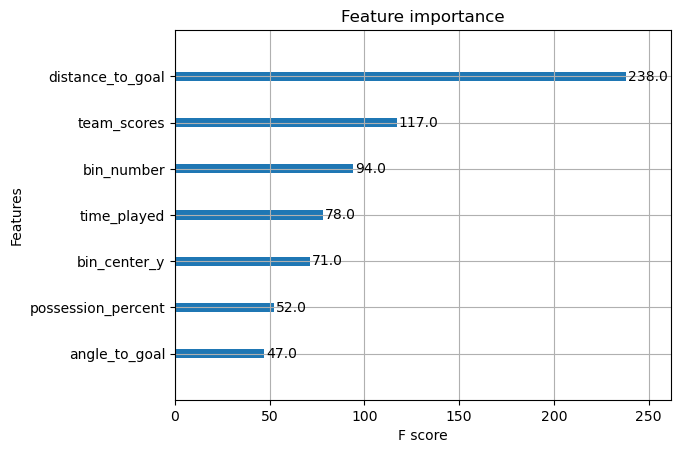

In [64]:
# Plottingg important features
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

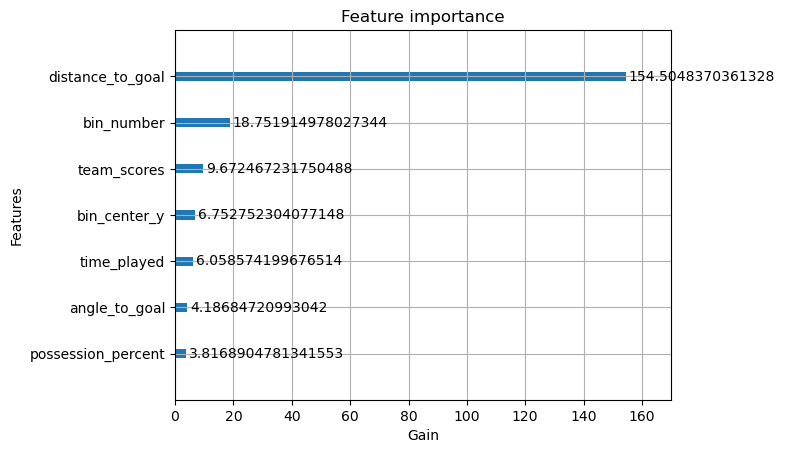

In [65]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

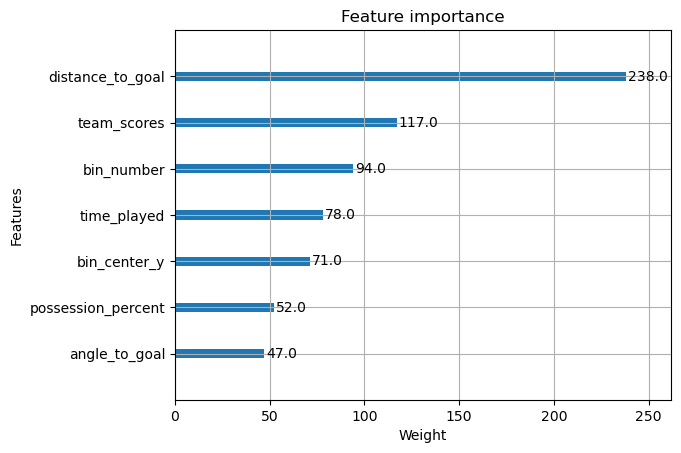

In [66]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

#  the second model : Random forest

In [67]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.8970380263984915
Weight of Goal Class in Training:  0.10296197360150848


In [68]:
#Define the hyperparameters to tune for BayesSearchCV
search_space_rf = {
    'max_depth': Integer(2, 7),
    'n_estimators': Integer(100, 500),  # Number of trees in the forest
    'min_samples_split': Integer(2, 25),  # Minimum samples to split an internal node
    'min_samples_leaf': Integer(2, 10),  # Minimum samples in a leaf node
    'bootstrap': Categorical([True, False]),  # Bootstrap sampling
    'class_weight': Categorical(['balanced', None])  # Handle class imbalance
}

In [69]:
# Define the random forest model
rf_model = RandomForestClassifier()
start_time = time.time()
# Perform nested cross-validation with grid search
bayes_search_rf = BayesSearchCV(rf_model, search_space_rf, cv=cv_inner,n_iter=25, scoring='neg_brier_score', n_jobs=-1, random_state=42)
scores_rf = cross_val_score(bayes_search_rf, X_train, y_train, cv=cv_outer, scoring='neg_brier_score', n_jobs=-1)

In [70]:
# Fit the best model on the entire training set
bayes_search_rf.fit(X_train, y_train)
best_rf_model = bayes_search_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [71]:
# Print the best parameters
print("Best parameters: ", bayes_search_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  OrderedDict([('bootstrap', False), ('class_weight', None), ('max_depth', 6), ('min_samples_leaf', 5), ('min_samples_split', 11), ('n_estimators', 185)])
Model Training Time: 2149.263 seconds


In [72]:
# Brier score on training data
rf_brs_train = brier_score_loss(y_train, best_rf_model.predict_proba(X_train)[:, 1])
# Classfication report for training data and brier score
print (f"{rf_brs_train} is the Brier score on training data" )

0.07873534391347499 is the Brier score on training data


In [73]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)
# Classfication report and brier score  for testing data
rf_brs_test = brier_score_loss(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print (f"{rf_brs_test} is the Brier score on testing data" )

0.07706582628163638 is the Brier score on testing data


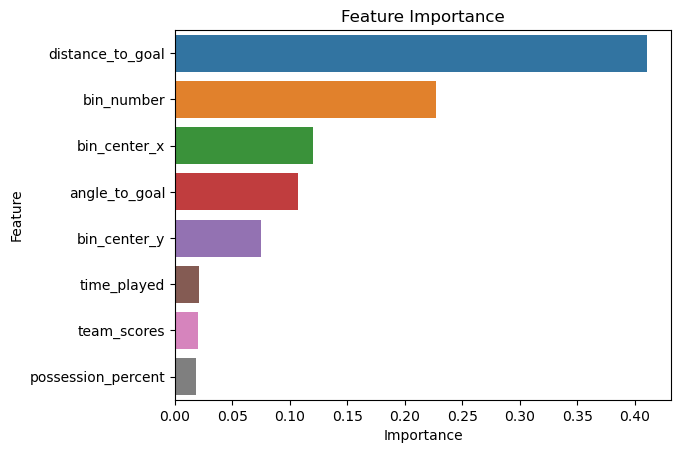

In [74]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

In [75]:

# Brier score for four models on training data
brs_train = [ xgb_brs_train, rf_brs_train, brier_baseline_train]
# Brier score for four models on test data
brs_test = [xgb_brs_test, rf_brs_test, brier_baseline_test ]
# Model training time
train_time =[xgb_training_time/60, rf_training_time/60, 0.1/60]

In [76]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['XG Boost','Random Forest', 'baseline'],
                          'Training Brier scores': brs_train,
                          'Testing Brier scores': brs_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =4).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Brier scores,Testing Brier scores,Training Time (mins)
Model Name,,,
XG Boost,0.0797,0.0769,7.5908
Random Forest,0.0787,0.0771,35.8211
baseline,0.0800,0.0771,0.0017


In [77]:
pickle.dump(best_xgb_model, open('xG_model.pkl', 'wb'))